# Risk assessment for heavy snowfall & blizzards

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [SNOW](https://github.com/CLIMAAX/SNOW) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Risk assessment methodology

The method involves visually representing the susceptible population exposed to intense snowfall and blizzards. This can be achieved by overlaying indicators for heavy snowfall and blizzards with population data. The objective is to understand the present probability of severe snowfall and blizzards, pinpointing the regions most impacted within Europe. Additionally, we seek to investigate how climate change may modify this exposure over time.


### Blizzard  

A blizzard is a severe storm condition defined by low temperature, sustained wind or frequent wind gust and considerable precipitating or blowing snow. For blizzard conditions we propose the use of following impact indicator:

**Blizzard days** = Tmean  ≤ 0 °C, Rs (snow amount) ≥ 10 cm and Wg (wind gust) ≥ 17 m/s ([Vajda et al., 2014](https://doi.org/10.1007/s11069-013-0895-4)). 

This impact indicator was defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. 


### Heavy Snow 

Heavy snowfall may cause many disruptions and impacts in various sectors; however, the impacts and consequences of this hazard depend on the affected sector, infrastructure and also preparedness of society that varies over Europe.  For example, already a few centimeters of snow can disrupt road traffic, but doesn’t normally cause any harm to energy infrastructure. Many weather services have three warning levels based on the severity of expected impacts, which are typically different for different sectors of infrastructure. There is a large variation in the national warning criteria or thresholds.

Similarly to blizzard, the impact indicators for heavy snowfall were defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. The qualitative description of the two-level thresholds are:

**1st threshold ( > 6 cm):** Some adverse impacts are expected, their severity depends on the resilience of the system, transportation is mainly affected.

**2nd threshold ( > 25 cm):**  The weather phenomena are so severe that is likely that adverse impact will occur, CI system is seriously impacted.

This code calculates the Annual probability (%) of a blizzard and heavy snowfall days during the specified period and a region of interest.


**The annual probability**

The annual probability is determined by dividing the count of events surpassing predefined thresholds within a year by the total number of days in that year. The result is then multiplied by 100 to express the probability as a percentage

    P = ((variable > threshold) / days in year ) X 100


## Preparation work

### Load libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [warnings](https://docs.python.org/3/library/warnings.html) - To control the Python warning message 
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [numpy](https://numpy.org) - Numerical computing tools  
- [xarray](https://docs.xarray.dev/en/stable/) - To process the NetCDF data and prepare it for further calculation
- [xesmf](https://xesmf.readthedocs.io/en/stable/) - Universal regridder for geospatial data
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [matplotlib](https://matplotlib.org/) - To plot the maps 
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
:::

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
warnings.filterwarnings('ignore', message='Adjusting dataset latitudes to avoid re-projection overflow')

import os

import pooch
import numpy as np
import xarray as xr
import xesmf as xe
import rioxarray as rxr

# Static map plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Interactive map plotting
import localtileserver
import folium
import branca

In [2]:
# Set host forwarding for remote jupyterlab sessions
if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ:
    os.environ['LOCALTILESERVER_CLIENT_PREFIX'] = f"{os.environ['JUPYTERHUB_SERVICE_PREFIX']}/proxy/{{port}}"

### Select area of interest

Before accessing the data, we will define the area of interest. Prior to commencing this workflow, you should have already prepared by downloading the heavy snowfall and blizzards hazard map to your local directory (using the [SNOW hazard workflow](./Hazard_assessment_SNOW_BLIZZARDS.ipynb) for heavy snowfall and blizzards or by using your own data). Please specify the name of the area for the snow hazard maps below.

In [3]:
areaname = 'Europe'

### Create the directory structure 

We need a directory structure for accessing and storing data.
If you have already executed the hazard assessment workflow, you have already created the workflow folder `SNOW_hazard` where the hazard data is stored.
We add additional data from this risk workflow notebook into the same folder.

In [4]:
workflow_folder = 'SNOW_hazard'
os.makedirs(workflow_folder, exist_ok=True)

In [5]:
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
os.makedirs(data_dir, exist_ok=True)

plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')
os.makedirs(plot_dir, exist_ok=True)

general_data_dir = os.path.join(workflow_folder, 'general_data')
os.makedirs(general_data_dir, exist_ok=True)

## Hazard data

### Intense snowfall and blizzards maps

As default option, we use the intense snowfall and blizzards maps from the [ERA5 single level dataset](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview) and [CORDEX single level dataset](https://cds.climate.copernicus.eu/datasets/projections-cordex-domains-single-levels?tab=overview), that were downloaded using the hazard assessment workflow for snow and blizzards.
Below we load the maps and visualize them to check the contents.

### Load EURO-CORDEX data

Choose the parameters as in the Hazard workflow to pick up the data produced there.

In [6]:
Hist_start_year    = '1991'
Hist_end_year      = '1995'
Hist_experiment_in = 'historical'

RCP_start_year     = '2046'
RCP_end_year       = '2050'

experiment_names  = ['rcp_2_6', 'rcp_4_5', 'rcp_8_5']
experiment_names1 = ['rcp26', 'rcp45', 'rcp85']
# Select the RCP scenario you want to use
experiment_choice = 0

RCP_experiment_in  = experiment_names[experiment_choice]
RCP_experiment_in1 = experiment_names1[experiment_choice]

ensemble_member_in = 'r1i1p1'

# List of model names
gcm_extr_list = [
    'NCC-NorESM1-M', 'MPI-M-MPI-ESM-LR', 'CNRM-CERFACS-CNRM-CM5',
    'CNRM-CERFACS-CNRM-CM5', 'NCC-NorESM1-M'
]
rcm_extr_list = [
    'GERICS-REMO2015', 'SMHI-RCA4', 'KNMI-RACMO22E',
    'CNRM-ALADIN63', 'SMHI-RCA4'
]
# Select the global and regional climate model combination you want to use
model_choice = 1

gcm_model_Name = gcm_extr_list[model_choice]
rcm_model_Name = rcm_extr_list[model_choice]

# Filename suffixes
cordex_suffix_hist = f'{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}'
cordex_suffix_fur = f'{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}'

print(RCP_experiment_in)
print(gcm_model_Name)
print(rcm_model_Name)

rcp_2_6
MPI-M-MPI-ESM-LR
SMHI-RCA4


Load CORDEX historical data

In [7]:
BdayCount_anaProb_mean_path = os.path.join(data_dir,f'BdayCount_AnaProb_mean_{cordex_suffix_hist}.nc')
BdayCount_anaProb_mean_hist = xr.open_dataarray(BdayCount_anaProb_mean_path, decode_coords='all')

snow6Prob_annual_mean_path = os.path.join(data_dir,f'Snow6Prob_annual_mean_{cordex_suffix_hist}.nc')
snow6Prob_annual_mean_hist = xr.open_dataarray(snow6Prob_annual_mean_path, decode_coords='all')

snow25Prob_annual_mean_path = os.path.join(data_dir,f'Snow25Prob_annual_mean_{cordex_suffix_hist}.nc')
snow25Prob_annual_mean_hist = xr.open_dataarray(snow25Prob_annual_mean_path, decode_coords='all')

Load CORDEX future data

In [8]:
# CORDEX Future
BdayCount_anaProb_mean_path = os.path.join(data_dir,f'BdayCount_AnaProb_mean_{cordex_suffix_fur}.nc')
BdayCount_anaProb_mean_fur = xr.open_dataarray(BdayCount_anaProb_mean_path, decode_coords='all')

snow6Prob_annual_mean_path = os.path.join(data_dir,f'Snow6Prob_annual_mean_{cordex_suffix_fur}.nc')
snow6Prob_annual_mean_fur = xr.open_dataarray(snow6Prob_annual_mean_path, decode_coords='all')

snow25Prob_annual_mean_path = os.path.join(data_dir,f'Snow25Prob_annual_mean_{cordex_suffix_fur}.nc')
snow25Prob_annual_mean_fur = xr.open_dataarray(snow25Prob_annual_mean_path, decode_coords='all')

### Load ERA5 data

In [9]:
BdayCount_anaProb_mean_path = os.path.join(data_dir,f'BdayCount_AnaProb_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')
BdayCount_anaProb_mean_ERA = xr.open_dataarray(BdayCount_anaProb_mean_path, decode_coords='all')

snow6Prob_annual_mean_path = os.path.join(data_dir,f'Snow6Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')
snow6Prob_annual_mean_ERA = xr.open_dataarray(snow6Prob_annual_mean_path, decode_coords='all')

snow25Prob_annual_mean_path = os.path.join(data_dir,f'Snow25Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')
snow25Prob_annual_mean_ERA = xr.open_dataarray(snow25Prob_annual_mean_path, decode_coords='all')

### Plotting functions



In [10]:
def plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1,
                     V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat):
    """Plot overlay plot variable with rotated grid and standard grid"""
    np.warnings.filterwarnings('ignore')
    # Create a figure and subplot
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 35))

    # Plot Var1 data
    p_var1 = var1.plot.contourf(ax=ax, levels=V1_p_levels, cmap=V1_cmap,
                                                                 transform=ccrs.PlateCarree(), alpha=0.5, add_colorbar=False)
    # Plot Var2 data
    p_var2 = var2.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), levels=V2_p_levels,
                                                                        cmap=V2_cmap, alpha=0.5, add_colorbar=False)
    # Set the extent of the plot to the specified latitude and longitude box
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

    # Add latitude and longitude labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Set title
    plt.title(Tit1, loc="left", fontsize=16)

    # Add colorbars
    cbar_var2 = fig.colorbar(p_var2, ax=ax, location='left', shrink=0.5,  pad=0.05)
    cbar_var2.set_label(V1_cb_tit)
    cbar_var1 = fig.colorbar(p_var1, ax=ax, location='right', shrink=0.5,  pad=0.05)
    cbar_var1.set_label(V2_cb_tit)
    plt.subplots_adjust(right=0.8, left=0.2)

    # Save the figure
    fig.savefig(fileout)

In [11]:
def plot_map_ERA5(var1, V1_p_levels, V1_cmap,Tit1, V1_cb_tit,fileout):
    """Plot ERA5 data"""
    np.warnings.filterwarnings('ignore')
    # Create a figure and subplot
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 35))

    # Plot Var1 data
    p_var1 = var1.plot.contourf(ax=ax, levels=V1_p_levels, cmap=V1_cmap,
                                                                 transform=ccrs.PlateCarree(), add_colorbar=False)

    # Add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

    # Add latitude and longitude labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Set title
    plt.title(Tit1, loc="left", fontsize=16)

    # Add colorbars
    cbar_var1 = fig.colorbar(p_var1, ax=ax, location='right', shrink=0.5,  pad=0.05)
    cbar_var1.set_label(V1_cb_tit)
    #plt.subplots_adjust(right=0.8, left=0.2)

    # Save the figure
    fig.savefig(fileout)

### Change in annual probability

Compute change of hazard indicators

In [12]:
def change(hist, fur):
    return (fur - hist).where(hist > 1, other=0).drop_vars(['rotated_pole', 'height'])

BdayCount_anaProb_mean_change = change(BdayCount_anaProb_mean_hist, BdayCount_anaProb_mean_fur)
snow6Prob_annual_mean_change = change(snow6Prob_annual_mean_hist, snow6Prob_annual_mean_fur)
snow25Prob_annual_mean_change = change(snow25Prob_annual_mean_hist, snow25Prob_annual_mean_fur)

In [13]:
def make_map(title=""):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={
        "projection": ccrs.Orthographic(0, 35)
    })
    ax.set_title(title, loc='left')
    # Add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')
    # Add latitude and longitude labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
            color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    return fig, ax


def plot_change(ax, change_data, max_level=1.0):
    "Plot preset for fields of change from CORDEX data"""
    levels = max_level * np.asarray([-1., -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1.])
    return change_data.plot.pcolormesh(
        ax=ax,
        x='lon',
        y='lat',
        transform=ccrs.PlateCarree(),
        levels=levels,
        extend='both',
        cmap='seismic_r',
        add_colorbar=True,
        cbar_kwargs={
            'label': '',
            'spacing': 'proportional',
            'shrink': 0.5
        }
    )

#### Change in Blizzard days probability

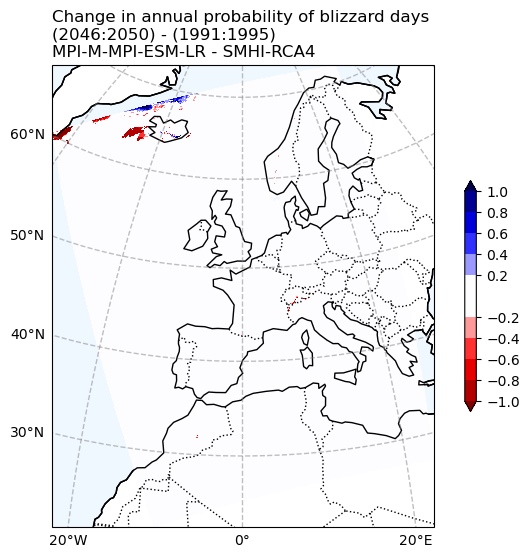

In [14]:
fig, ax = make_map(
    'Change in annual probability of blizzard days\n'
    f'({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year})\n'
    f'{gcm_model_Name} - {rcm_model_Name}'
)

plot_change(ax, BdayCount_anaProb_mean_change, max_level=1.)

fig.savefig(os.path.join(plot_dir, f'Chan_Ann_prob_blizzard_days_CORDEX_{cordex_suffix_fur}.png'))

#### Change in snowfall days > 6 cm probability

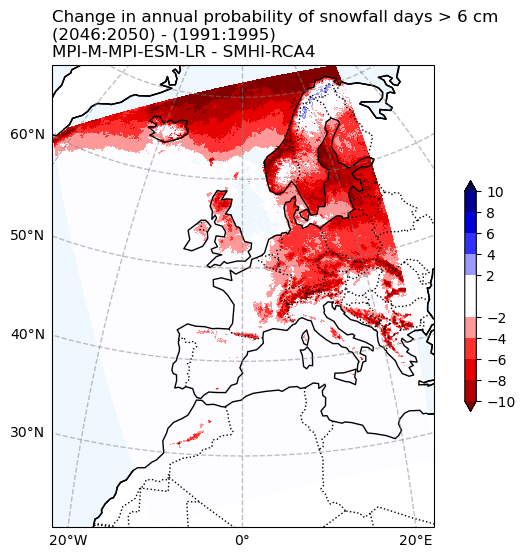

In [15]:
fig, ax = make_map(
    'Change in annual probability of snowfall days > 6 cm\n'
    f'({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year})\n'
    f'{gcm_model_Name} - {rcm_model_Name}'
)

plot_change(ax, snow6Prob_annual_mean_change, max_level=10.)

fig.savefig(os.path.join(plot_dir, f'Chan_Ann_prob_snow_days_6_CORDEX_{cordex_suffix_fur}.png'))

#### Change in snowfall days > 25 cm probability

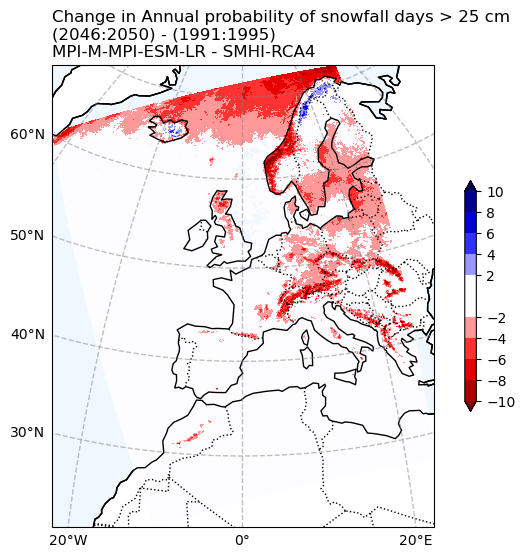

In [16]:
fig, ax = make_map(
    'Change in Annual probability of snowfall days > 25 cm\n'
    f'({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year})\n'
    f'{gcm_model_Name} - {rcm_model_Name}'
)

plot_change(ax, snow25Prob_annual_mean_change, max_level=10.)

fig.savefig(os.path.join(plot_dir, f'Chan_Ann_prob_snow_days_25_CORDEX_{cordex_suffix_fur}.png'))

## Exposure data

### Download population data

In this illustration, we are using population data sourced from the JRC data portal, specifically the Global Human Settlement Layer [Global Human Settlement Layer GHSL](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop), with 30 arcsec resolution global datasets. After downloading and extracting the data, Pooch will list the contents within the data directory. 

In [17]:
pop_files = pooch.retrieve(
    url='https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2015_GLOBE_R2023A_4326_30ss/V1-0/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.zip',
    known_hash=None,
    path=general_data_dir,
    processor=pooch.Unzip(extract_dir=''),
    progressbar=True
)

The zip file contains data, as well as metadata and the documentation in the pdf file.


### Load the data

Population data is in file with filename: **GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif**

We can use rioxarray to load this file and explore the projections of the dataset.

In [18]:
population_file = os.path.join(general_data_dir, 'GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif')

population = rxr.open_rasterio(population_file)
population

<xarray.DataArray (band: 1, y: 21384, x: 43202)> Size: 7GB
[923831568 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 171kB 89.1 89.09 89.08 ... -89.08 -89.09 -89.1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        267987.44849293
    STATISTICS_MEAN:           8.0389086783221
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         224.24651928593
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

The population data has **x** and **y** as spatial dimensions, which are really **longitude** and **latitude** coordinates given in degrees.

In [19]:
population.rio.crs

CRS.from_epsg(4326)

The projection is **WSG84/EPSG:4326**.

## Explore the data

In [20]:
pop_client = localtileserver.TileClient(os.path.join(general_data_dir, 'GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif'))

In [21]:
max_color_val = 2000
cmap = "afmhot_r"

layer_base = folium.TileLayer("http://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png", attr="CartoDB")
layer_labels = folium.TileLayer("http://{s}.basemaps.cartocdn.com/light_only_labels/{z}/{x}/{y}.png", attr="Carto")
layer_pop = localtileserver.get_folium_tile_layer(
    pop_client,
    colormap=cmap,
    vmin=0,
    vmax=max_color_val,
    nodata=0.0,
    name='Population'
)

m = folium.Map(tiles=layer_base, location=[52, 10], zoom_start=4, control_scale=True)
m.add_child(layer_pop)
m.add_child(layer_labels)
m.add_child(branca.colormap.LinearColormap(
    colors=plt.colormaps["afmhot_r"](np.linspace(0, 1.0, 50)).tolist(),
    vmin=0,
    vmax=max_color_val
))

m

:::{tip}

Execute the notebook to see the interactive population data map.
:::

### Process the data

We want to overlay the population data on snowfall and blizzard indicators to better understand where these indicators affect densely populated areas. 

To be able to combine the climate and population datasets, we must have them at the same resolution and zoomed in to the same area.

To regrid the data, we utilize the xESMF library, a Universal Regridder for Geospatial Data, to regrid the population data to match the ERA5 resolution. Prior to regridding, the population data is cropped specifically for the European region.

In [17]:
Europe_population = population.sel(latitude=slice(80.0,20.0), longitude=slice(-10.0,45.0))
snow6Prob_annual_mean_ERA.rio.write_crs(4326, inplace=True)
snow6Prob_annual_mean_ERA.rio.crs

CRS.from_epsg(4326)

In [18]:
# Building the regridder can take a while
regridder = xe.Regridder(Europe_population, snow6Prob_annual_mean_ERA, 'bilinear', periodic=True)

Europe_population_025deg = regridder(Europe_population)

del Europe_population_025deg['band']
del Europe_population_025deg['spatial_ref']

Europe_population_025deg.to_netcdf(path=os.path.join(data_dir, "Europe_population_25deg.nc"))

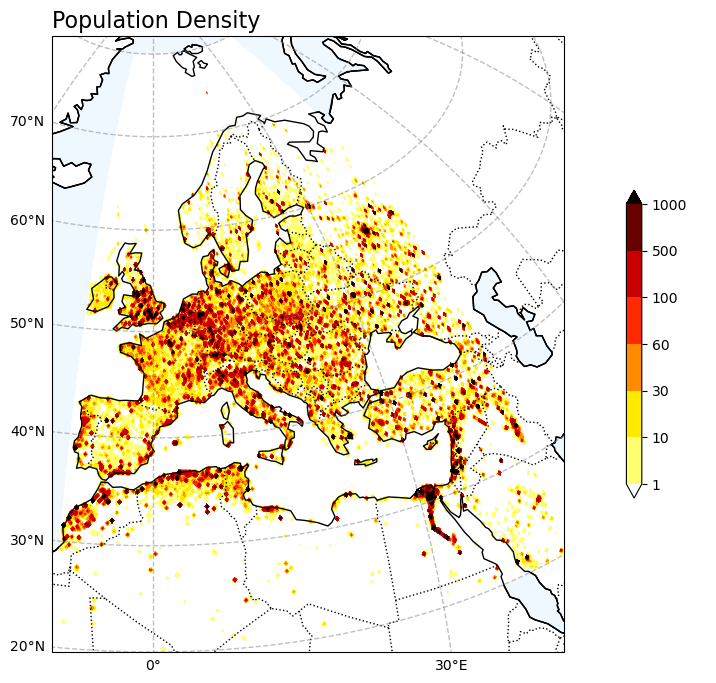

In [19]:
# Explore the Population Density
var1 = np.squeeze(Europe_population_025deg)
V1_p_levels =  [1, 10, 30, 60, 100, 500, 1000]
V1_cmap = "hot_r"
Tit1 = 'Population Density'
V1_cb_tit = ' '
fileout = os.path.join(plot_dir, 'Population_Density.png')

plot_map_ERA5(var1, V1_p_levels, V1_cmap, Tit1, V1_cb_tit, fileout)

## Plot the results
### Select the area of interest
We are currently selecting the Alpine region because population density is higher in this area, and there is also a greater probability of heavy snow and blizzards, using the specified latitude and longitude extents, which can be modified as needed.


In [21]:
xmin=4  # Min Longitude
xmax=15 # Max Longitude

ymin=42 # Min Latitude
ymax=50 # Max Latitude

SelArea_population  = Europe_population_025deg.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))

SelArea_6cm_ind     = snow6Prob_annual_mean_ERA.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))
SelArea_25cm_ind    = snow25Prob_annual_mean_ERA.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))
SelArea_blizard_ind = BdayCount_anaProb_mean_ERA.sel(latitude=slice(ymax,ymin), longitude=slice(xmin,xmax))

### To explore the exposure and vulnerability of the population, plot them together

We are exclusively plotting snow indices in regions where the population density exceeds 1/km.

### Plot population with Historical snow indices
#### Annual probability (%) of snowfall exceeding 6 cm vs population density

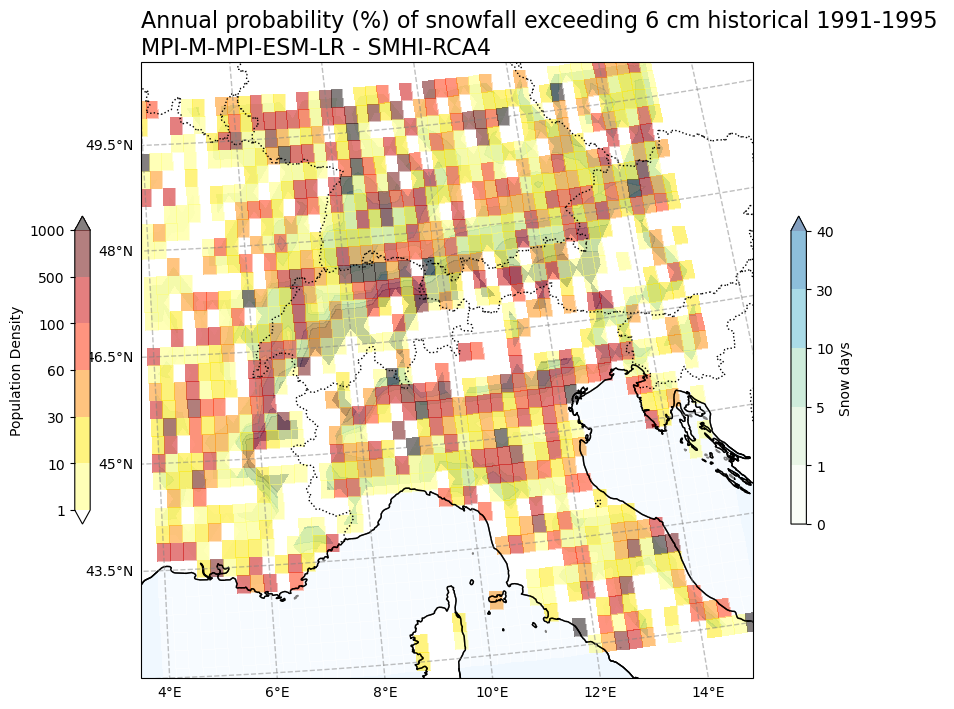

In [22]:
# Create a mask for snow data where population density is below 1
SelArea_6cm_ind_masked = SelArea_6cm_ind.snow_days.where(SelArea_population >= 1)
SelArea_25cm_ind_masked = SelArea_25cm_ind.snow_days.where(SelArea_population >= 1)
SelArea_blizard_ind_masked = SelArea_blizard_ind.blizzard_days.where(SelArea_population >= 1)

population_masked_Blizard = SelArea_population.where(SelArea_blizard_ind.blizzard_days > 0)

min_lon = xmin
max_lon = xmax
min_lat = ymin
max_lat = ymax

SelArea_population = SelArea_population.rename({'longitude': 'lon','latitude': 'lat'})

var1 = np.squeeze(SelArea_6cm_ind_masked)
var2 = np.squeeze(SelArea_population)

V1_p_levels = [0, 1, 5, 10, 30, 40]
V2_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V1_cmap = "GnBu"
V2_cmap = "hot_r"

Tit1 = f'Annual probability (%) of snowfall exceeding 6 cm {Hist_experiment_in} {Hist_start_year}-{Hist_end_year} \n{gcm_model_Name} - {rcm_model_Name}'
V1_cb_tit = 'Population Density'
V2_cb_tit = 'Snow days'

fileout = os.path.join(plot_dir,f'Population_Density_Annual_probability_snowfall_days_6cm_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.png'.format(areaname))
plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

#### Annual probability (%) of snowfall exceeding 25 cm vs population density

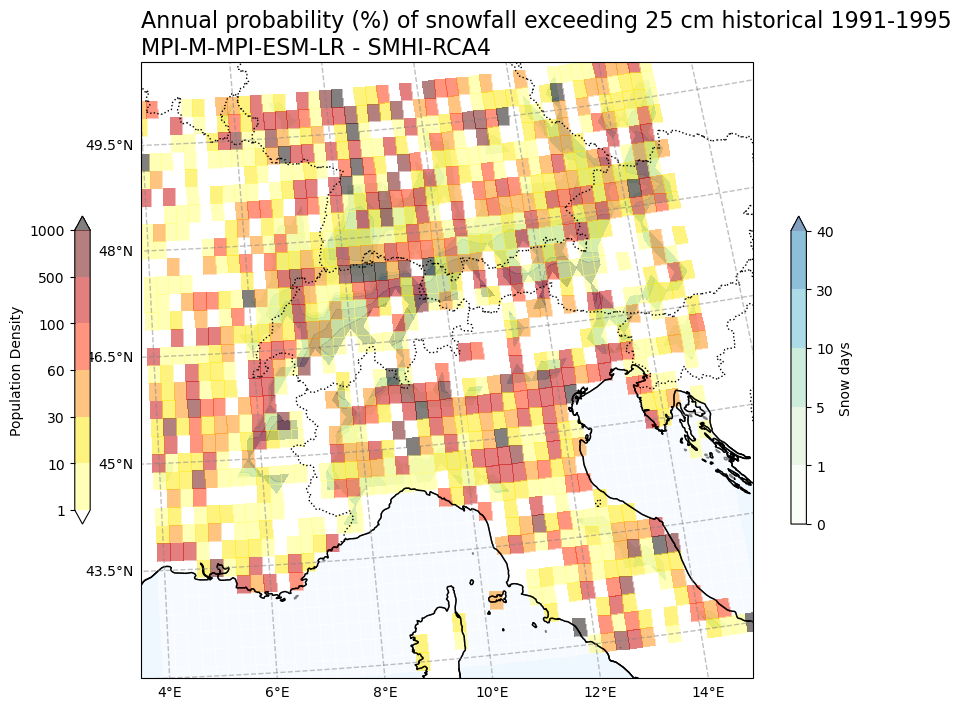

In [23]:
# Create a mask for snow data where pollution density is below 1
var1 = np.squeeze(SelArea_25cm_ind_masked)
var2 = np.squeeze(SelArea_population)

V1_p_levels = [0, 1, 5, 10, 30, 40]
V2_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V1_cmap = "GnBu"
V2_cmap = "hot_r"

Tit1 = f'Annual probability (%) of snowfall exceeding 25 cm {Hist_experiment_in} {Hist_start_year}-{Hist_end_year} \n{gcm_model_Name} - {rcm_model_Name}'

V1_cb_tit = 'Population Density'
V2_cb_tit = 'Snow days'

fileout = os.path.join(plot_dir,f'Population_Density_Annual_probability_snowfall_days_25cm_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

#### Annual probability (%) of blizzard days vs population density

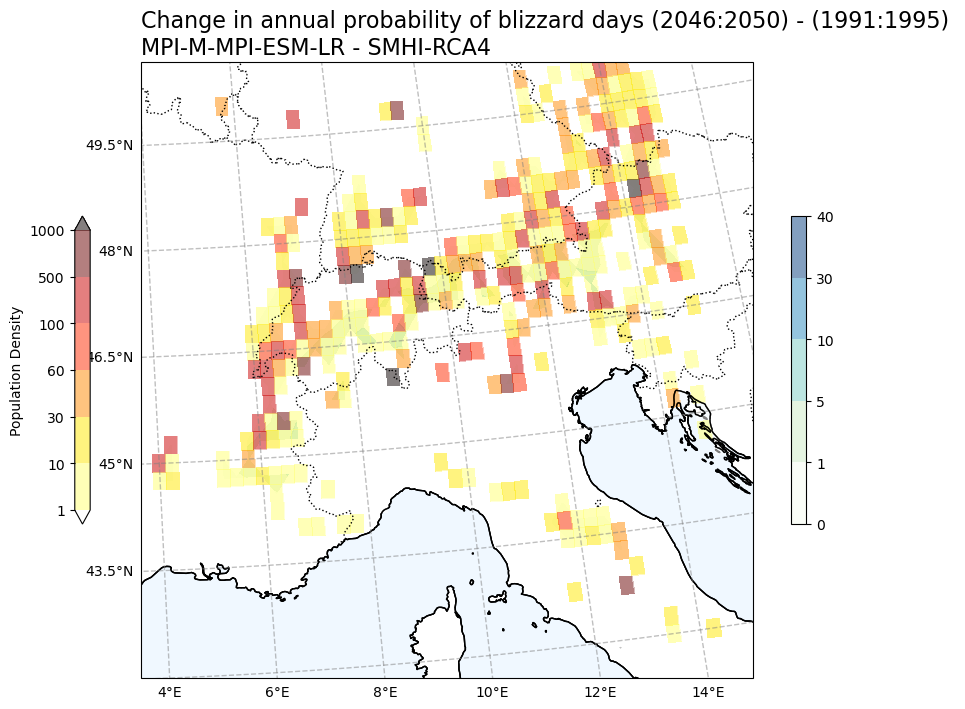

In [24]:
population_masked_Blizard = population_masked_Blizard.rename({'longitude': 'lon','latitude': 'lat'})

var1 = np.squeeze(SelArea_blizard_ind_masked)
var2 = np.squeeze(population_masked_Blizard)

V1_p_levels = [0, 1, 5, 10, 30, 40]
V2_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V1_cmap = "GnBu"
V2_cmap = "hot_r"

Tit1 = f'Change in annual probability of blizzard days ({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year}) \n{gcm_model_Name} - {rcm_model_Name}'
V1_cb_tit = 'Population Density'
V2_cb_tit = ' '

fileout = os.path.join(plot_dir,f'Population_Density_Annual_probability_blizzard_CORDEX_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

### Plot population with change in snow indices

#### Change in Annual probability (%) of blizzard days vs population density

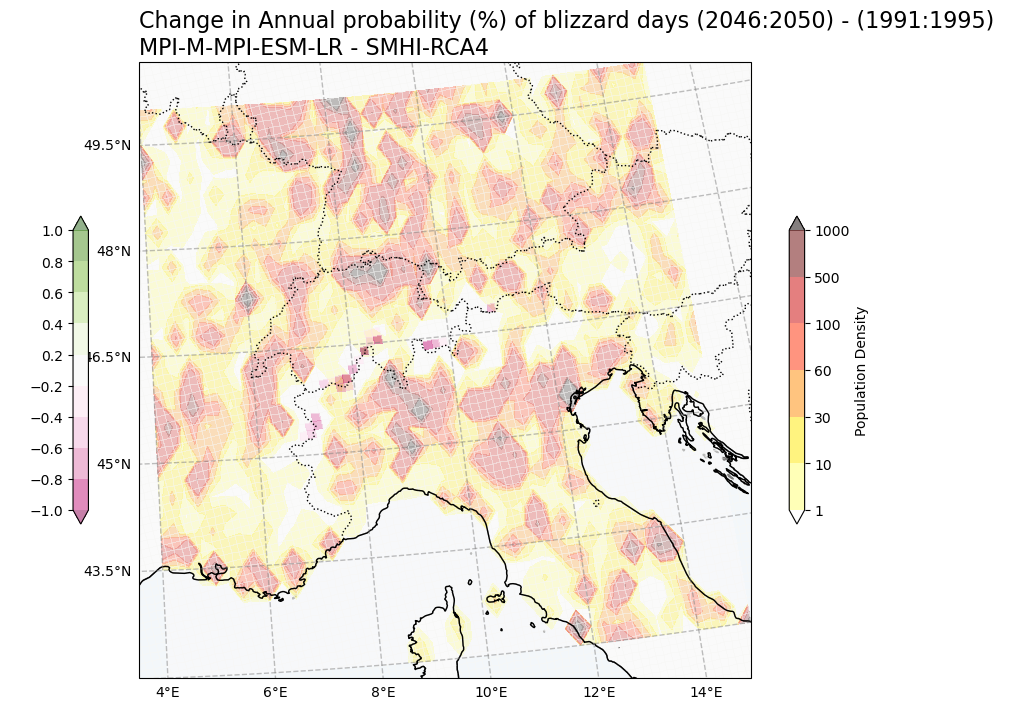

In [25]:
var2 = np.squeeze(BdayCount_anaProb_mean_change.blizzard_days)
var1 = np.squeeze(SelArea_population)

V2_p_levels = [-1, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 1]
V1_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V2_cmap = "PiYG"
V1_cmap = "hot_r"

Tit1 = f'Change in Annual probability (%) of blizzard days ({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year}) \n{gcm_model_Name} - {rcm_model_Name}'
V2_cb_tit = 'Population Density'
V1_cb_tit = ' '

fileout = os.path.join(plot_dir,f'Population_Density_Annual_probability_blizzard_CORDEX_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

#### Change in Annual probability (%) of snowfall days > 6 cm vs population density

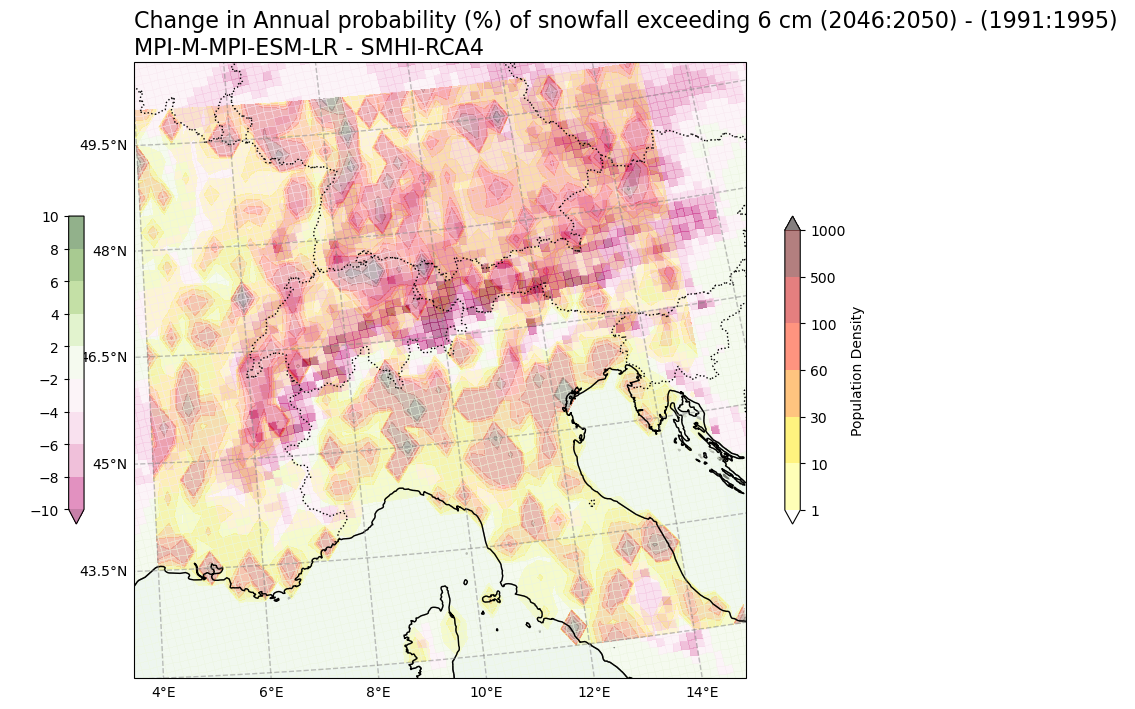

In [26]:
var2 = np.squeeze(snow6Prob_annual_mean_change.snow_days)
var1 = np.squeeze(SelArea_population)

V2_p_levels = [-10, -8, -6, -4, -2, 2, 4, 6, 8, 10]
V1_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V2_cmap = "PiYG"
V1_cmap = "hot_r"

Tit1 = f'Change in Annual probability (%) of snowfall exceeding 6 cm ({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year}) \n{gcm_model_Name} - {rcm_model_Name}'
V2_cb_tit = 'Population Density'
V1_cb_tit = ' '

fileout = os.path.join(plot_dir,f'Population_Density_Annual_probability_snowfall_days_6cm_CORDEX_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

#### Change in Annual probability (%) of snowfall days > 25 cm vs population density

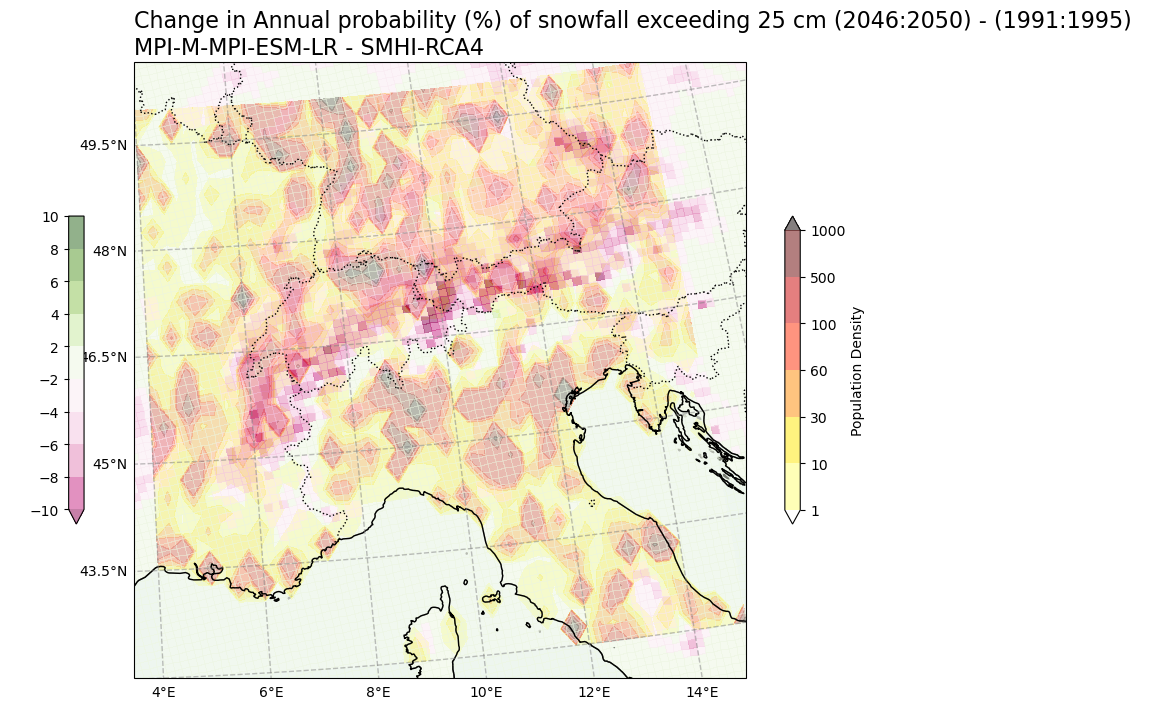

In [27]:
var2 = np.squeeze(snow25Prob_annual_mean_change.snow_days)
var1 = np.squeeze(SelArea_population)

V2_p_levels = [-10, -8, -6, -4, -2, 2, 4, 6, 8, 10]
V1_p_levels =  [1, 10, 30, 60, 100, 500, 1000]

V2_cmap = "PiYG"
V1_cmap = "hot_r"

Tit1 = f'Change in Annual probability (%) of snowfall exceeding 25 cm ({RCP_start_year}:{RCP_end_year}) - ({Hist_start_year}:{Hist_end_year}) \n{gcm_model_Name} - {rcm_model_Name}'
V2_cb_tit = 'Population Density'
V1_cb_tit = ' '

fileout = os.path.join(plot_dir,f'Population_Density_Annual_probability_snowfall_days_25cm_CORDEX_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.png'.format(areaname))

plot_overlay_map(var1, var2, V1_p_levels, V2_p_levels, V1_cmap, V2_cmap, Tit1, V1_cb_tit, V2_cb_tit,fileout,min_lon, max_lon, min_lat, max_lat)

## Conclusions
In this workflow, we've illustrated the process of exploring, processing, and visualizing data necessary for analyzing the influence of heavy snowfall and blizzard day indices on population density. These indices are presented as annual probabilities of occurrence, reflecting the likelihood of a particular event happening over several years. In the present climate, communities in the northern Alpine region face heightened vulnerability to heavy snowfall and blizzards. However, under the RCP2.5 scenario, we observe a significant reduction in the severity of these hazards across the region by mid-century compared to the current climate. Please note that this analysis is based on a single model and only 5 years of data. For greater accuracy, a 30-year period of data should be used, along with multi-model simulations to better account for model uncertainty.

## Contributors

- Suraj Polade, Finnish Meteorological Institute
- Andrea Vajda, Finnish Meteorological Institute